# Machine Learning in Python - Project 2


Finlay Young, Rachel Dance, Silvia Cecilia Hernandez Vargas

# Setup

In [79]:
# Install required packages
!pip install -q -r requirements.txt

In [163]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np
import geopy.distance as gpy
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
import pycountry as pyc
import ccy

#Web Scraping Requirement
import datapackage

#Import file
import external_functions

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, plot_roc_curve
from sklearn.metrics import confusion_matrix,classification_report, precision_score
from sklearn.ensemble import RandomForestClassifier

In [82]:
# Load data
d = pd.read_csv("hotel.csv")
n_observations, n_features = d.shape[0], d.shape[1]
print(f'Data contains {n_features} features and {n_observations} observations')

Data contains 30 features and 119390 observations


# 1. Introduction

In this project we analyse hotel booking data as given in the file 'hotel.csv', which was collected by [Antonio, Almeida and Nunes, 2019](https://www.sciencedirect.com/science/article/pii/S2352340918315191#f0010). This data was gathered for hotels located in Portugal: H1 at the resort region of Algarve and H2 at the city of Lisbon. There are 119,390 samples between July 1st, 2015 through August 31st 2017.

While cleaning and anlysing the data, we discovered the advantange of creating and removing features from the original data and thus in order to enhance our analysis and to further improve the model provided for predicting a cancellation, additional datasets were introduced. A full description of these datasetsis is given in Section 2b, but briefly they consist of:
- 'currency_exchange_rates_02-01-1995_-_02-05-2018.csv' - exchange rates between Jan 1995 and May 2018
- 'ISO 3155' - country three letter codes
- 'countries_coords' - central coordinates of countries in dataset
- 'curr_codes' - codes depicting country currencies


Our modeling approach is to test 4 different models: i)Logistic Regression, ii) Support Vector Machines, iii) Classifier trees and iv) Random Classifier trees. Given that we are concerned about false positives in cancellations, we decided to stay with the Random Forest Classifier as it has a % of false positives cancellations. In all cases we split the data into two sets, where 80% (89600 points) of the data is used for training, and 20% (22400 points) for testing in all models. It is important to mention that we did not realise any techique to fix 'unbalanced data' given that we considered that the percentage of cancellation in the data (37%) does not necessarily represent an issue for our prediction.

We obtain the best modeling solution with the random forest model. We have chosen this as we not only want to observe good performance in terms of number of correct predictions, but we also would like to minimise the number of false positive cases which this model accomplishes. We achieve a 40% true positive prediction and 99.5% true negative prediction, with only .5% false positive and 60% false negative outcomes. We appreciate there is a cost associated with both false cases, but we have prioritised minimising false positive as not only is this a loss of business, but there is an associated cost. We discovered that the top three features that contribute to a booking cancellation are:
- deposit type non deposit: if the guests did or did not gave a deposit for booking.
- deposit type non refund: if the guests have a non refundable deposit for booking.
- country Portugal: if the bookings come from Portugal.

This is not an exhaustive list and more details are given in the Discussion section.

The principal limitations we encountered are: i) computational limitation for running every model with the grid search desired, specially for support vector machines, where eventhough this model is not recommended for large dataset we wanted to compare the results given, ii) Assumptions made by cleaning the data, eg. null value in 'children' feature was fixed by filling with zeros or duplicated data, and iii) lack of more precise data, in particular we wish we had more information about costs of cancelling in oirder to have a better quantification of false positives cases.


# 2. Exploratory Data Analysis and Feature Engineering

## Data Cleaning
#### Core issues

The following observations and actions were taken from initial analysis of the source data provided by the client: 


 **`Children` ** : 'nan' valued children were replaced with zeros - this makes the assumption of an error in data entry, i.e. it was omitted when filling this field in for no children.

**`company` & `agent`** : 94% of the company feature is null, which we might expect is an error from filling this field. In the same way, 13% of the `agent` feature is null. However, given that many `agent` values would correspond to a specific company, this still allows for the booking to be attributed to a known agent with more granularity than `company`. Therefore, even both features are sparsly populated we will retain for further analysis. 

**`country`** : Null (415 instances) country codes have been assumed by default to PRT (Portugal), given that the hotels are in Portugal and make up 32% of all bookings are from Portugal. On the other hand, this variable should follow a 3 character code (ISO 3155); nevertheless, there is an alpha-2 code for "CN", which corresponds to China. This has been changed from "CN" to "CNH".

**`adr`** : There exists data where the feature 'adr' contains zero as a value, which we might expect to be an error in the data as it is not possible to have no expenses during the accomodataion. Our first attempt was to replace this 'zero' values with the average expenses given the reserved room type, assigned room type and type of meal. However, the percentage of the data with no value is low in comparison with the whole data (1.6%). Therefore, we decided to delete the rows which this characteristic from the data.

In the source dataset there are ~32,500 duplicate rows of data. However, for the porpouse of this task as we are investigating what will indicate cancellations, and not the overall booking, mainting this data will be useful for achieving this goal. Furthermore, it would be fair to assume these were all "double bookings" where multiple groups of friends (or coincidental) booking for the same holiday in different transactions, or for a popular event - for this reason we will not be dropping these duplicates. In fact, 90% of the duplicates are reservations for the City hotel, and thus by removing this data we might get rid of potentially useful data. 


In [84]:
#Changing nan children to zero childrem 
d['children'] = np.where(d['children'].isnull(),0,d['children'])

# Update China CN-> CNH. & Adding PRT to nan Countries. 
d['country'] = d['country'].replace(np.nan, 'PRT')
d['country'] = d['country'].replace('CN', 'CNH')

## Feature Analysis


#### Booking type

We investigate the relationship between features `distribution_channel`, `market_segment`, `company` and `agent`, in order to determine if these features are dependent on one other, and not provide add value to the model. In the following first graph we can see how `market_segment` can be considered as a child of `distribution_channel`. Therefore, keeping only `market_segment` will provide a more meaningful description without loss of information. We also see that five types of `market_segment` are dominant over the others (see bullet 2 below). 

In the second graph we analyse the interaction between `market_segment`, `company` and `agent`.  We find the majority of the data provided for `company` is null (>90%). Additionally, there are agents in which the same agent appears in multiple companies, thus agents can not be related to a single company.

From this, the following decision were taken:

- Drop `distribution channel` field and only retain `market segment` feature for describing where bookings are originated from.
- Retain the market segment for: 'Online TA', 'Offline TA/TO', 'Groups', 'Direct' and 'Corporate'; and relabeled the rest of the market segments as "other".
- Drop `agents` and `company` fields, as they add complexity to the data but not necessarily adding much in the way of insight.
- Company & Agent were both altered to include a "Company ID" & "Agent ID" prefix for easier reading. 


In [86]:
# Form datafram for plotting
d_cat_cut = d.groupby(['distribution_channel', 'market_segment']).agg({'meal':'count'}).reset_index()
d_cat_cut.rename(columns = {'meal' : 'Counts'}, inplace = True)

fig = px.parallel_categories(d_cat_cut, color="Counts", color_continuous_scale=px.colors.sequential.Inferno,
    title = 'Relation between distribution channel and market segment')
fig.show()

![Picture title](spider-distribution.png)

In [88]:
# Add "Agent ID & "Company ID" prefixes 
d['company'] = np.where((d.company.isnull()),np.nan,'Company ID: '+ d["company"].map(str))
d['agent'] = np.where((d.agent.isnull()),np.nan,'agent ID: '+ d["agent"].map(str))

# Table data showing the market sector, company and agent dependency
# Visualisation of table data:
booking_means = d.groupby(['market_segment',"company", "agent",]).agg({'meal':'count'}).reset_index()
booking_means.rename(columns = {'meal' : "Counts"}, inplace = True)
fig = px.treemap(booking_means, path=['market_segment',"company", "agent",], values='Counts', 
            title = 'Relation between market segment, company and agent feature.')
fig.show()

![Picture title](segment.png)

In [89]:
market_retain = ['Online TA', 'Offline TA/TO', 'Groups', 'Direct', 'Corporate']
d['market_segment'] = np.where( d['market_segment'].isin(market_retain) , d['market_segment'], 'Other')

#### Reserved room types

In this case, we make an analysis of the interaction between `reserved_room_type` and `assigned_room_type`. From the following plot, it can be seen that for both the resort hotel and city hotel, in the vast majority of the cases, the room reserved is the same as the room assigned. Therefore, we assume information in these two features might be equally the same. We expect that, in order to get a better prediction, a more important feature than any individual room type is whether any customer gets what they asked for - i.e. the reserved room matches the room recieved. 

From the previous analysis, the following decision were taken:

- Retain the the feature `reserved_room_type` as this might be relevant for predicting a cancellation. For example, this feature can have an interaction with the feature `deposit_type` as a guest might be less probable to cancel a reservation given that he made a `Non Refund` deposit for an expensive type of room.

- Create a new feature `room_granted` with a boolean type, where if true then the reserved room type is the same as the room assigned.

In [90]:
fig = px.parallel_categories(d[['hotel','reserved_room_type','assigned_room_type' ]], color_continuous_scale=px.colors.sequential.Inferno,  title = 'Relationship between rooms book & books assigned per hotel ')
fig.show()

![Picture title](image-20210416-004043.png)

In [92]:
d['room_granted'] = np.where(d["reserved_room_type"] == d["assigned_room_type"], True, False)

#### Booking date

The date of the booking and of the hotel stay is kept in the dataframe, but arrival year & week number are omitted. Year is non-sensical as described above, and the week number is a duplication of information we can more meaningfully obtain from the month of the booking. The month feature is more than adequate feature to identify seasonal changes. The dataset consists of 24 months of data spanning three years, and as such we only have one complete year, so we cannot do a comparison of a set month over the three years, but we will keep month as a feature.

The following plot shows that for both the city and resort hotel, from November to January, number of cancellations register the lowest number of occurrence. Eventhough, for the rest of the months both type of hotels does not necessarilly have the same correlation their behaviour is merely the same.

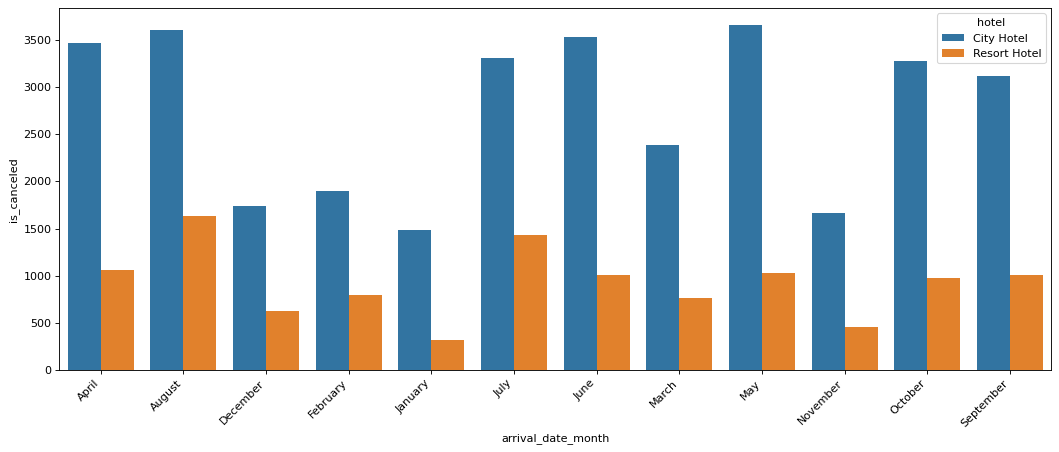

In [96]:
months_cancel = d.groupby(['arrival_date_month','hotel']).agg({'is_canceled':'sum'}).reset_index()

fig, ax = plt.subplots(figsize=(16, 6))

#sns.barplot(x ='arrival_date_month', y = 'adults',hue = "is_canceled", data = d)
sns.barplot(x ='arrival_date_month', y = 'is_canceled',hue = 'hotel', data = months_cancel , )

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

#### Lead time, babies and children

All Violin plots are scaled by area to make the comparable. We see right away that very few bookings have children, and fewer still have babies. This is marginally lower numbers in the City hotel than in the Resort which is not surprising. For lead time, in both hotels the frequency of is canceled tapers off with lead time - i.e. are people more likely to cancel the later they book.

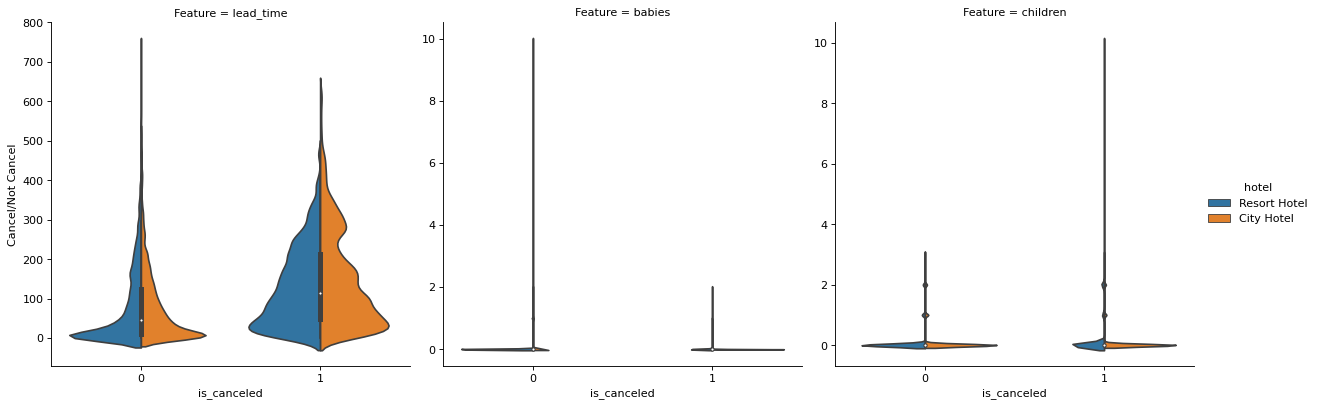

In [97]:
g = sns.catplot( data = d.melt(id_vars = ['is_canceled','hotel'],value_vars = ['lead_time','babies','children'],var_name = 'Feature',value_name = 'Cancel/Not Cancel'),
                    x = 'is_canceled', y = 'Cancel/Not Cancel', hue = 'hotel', kind = 'violin', col = 'Feature' , scale = 'area', sharey= False, split=True)

##### Required Car parking spaces
We look initially to see how balanced the data is with regard to `required_car_parking_spaces` feature. All of the 44,224 cancellations occur in bookings with 0 parking spaces, therefore we might expect that the feature is not going to be able to enhance model predictions. For this reason, this feautre will be removed.

In [98]:
percent_needing_spaces = d['required_car_parking_spaces'].value_counts()[0]/len(d['required_car_parking_spaces'])
print(f'{round(percent_needing_spaces,2)*100}% of bookings required no parking at all.')

94.0% of bookings required no parking at all.


## Feature Analysis - External Data & Preprocessing 

Aside from cleaning & preprocessing the main hotels data, there was considerable processing of data which was joinned to give additional features. The summary of these additional datsets is:


**cur_code**

 - **Dataset Info**: This is a [Google Dataset](https://developers.google.com/public-data/docs/canonical/countries_csv) which maps 3-Alpha Currency code & Name to a 3-Alpha Country code.

 - **Decription of Preprocessing**: This dataset was used to enrich fx_rates with the Aphabetic Currency code. The preprocessing here was an iterative task, and involved renaming many of the currencies within fx_rates to ensure a match, which would then allow for the enriched fx_rates . 
 

**coords**

 - **Dataset Info**: This is also a [Google Developers dataset](https://developers.google.com/public-data/docs/canonical/countries_csv). which provides a 2-Alpha character code mapping to Londitude & Latidude of listed countries. 

 - **Decription of Preprocessing**: Using the Longditude & Latitude we were able to calculate the Orthodoric (spherical) distance between each country of the world to Portugal, where both the hotel resorts are. This distance in kilometers was then able to be joined onto the main 'Hotels.csv' dataset. This enrichment will be able to give further depth & understanding on each guests decision to cancel if we assume that a greater distance implies a longer transportation time, and more expensive means of transportation.

**comp_countries**

 - **Dataset Info**: This DataFrame hold geographical data which allows for better description of a country, as well as holding the Countries Currency code, and  2&3-Alpha character codes. This is a [published dataset on Datahub](https://datahub.io/core/country-codes) 

 - **Decription of Preprocessing**: The majority dataset was not used, the data in this dataset was for mapping data between 'hotels.csv', coords and fx_date to ensure that there are consistent country & currency codes to join on. 

**fx_rates**

 - **Dataset Info**: This is a dataframe of daily currency Exchange rates from 1995 - 2018, for 50+ currencies, with an exchange rate with respect to US Dollars. This is an available [Kaggle dataset](https://www.kaggle.com/thebasss/currency-exchange-rates).
 
 - **Decription of Preprocessing**: Given that there are exchange rates from 1995 - 2018, this data was needed to be cut down to start at the earliest booking date from 'hotels.csv' up to the last arrival date.The rationale for this was to ensure we could enrich the main dataset with an exchange rate from the customers home currency at the point of booking their holiday (booking date) and compare this with an exchange rate percentage on their arrival (arrival date) of their holiday. The data required to first be calculated from US Dollar exchange rates into Euro exchange rates. The data also had many missing dates, which were sundays, which meant that many arrival & booking dates were not within the fx_rates dataset. To fix this, all dates were added between the first booking date & arrival date, and the missing exchange rates were linearly interpolated. 

To summarise, the additional data sources shall allow for the dataset to hold how far away from the booking country is, and the relative difference in currency strength between the time of the guest booking to arriving.  

In [99]:
cur_code = pd.read_csv("curr_codes.csv")
coords = pd.read_csv("countries_coords.csv")
fx_rates = pd.read_csv("/work/currency_exchange_rates_02-01-1995_-_02-05-2018.csv")

data_url = 'https://datahub.io/core/country-codes/datapackage.json'
# to load Data Package into storage
package = datapackage.Package(data_url)
# to load only tabular data
resources = package.resources
for resource in resources:
    if resource.tabular:
        comp_countries = pd.read_csv(resource.descriptor['path'])

In [100]:
#format arrival date
d['month'] = pd.to_datetime(d.arrival_date_month, format='%B').dt.month
d['day'] = pd.to_datetime(d.arrival_date_day_of_month, format='%d').dt.day
d['Year'] = pd.to_datetime(d.arrival_date_year, format='%Y').dt.year
d['arrival_date']  = pd.to_datetime(d[['Year','month','day']], format = '%Y%m%d')#.dt.date
d['booking_date'] = d['arrival_date'] - pd.to_timedelta(d['lead_time'], unit='d')

min_date = d['arrival_date'].min()
max_date = d['arrival_date'].max()
min_booking_date = d['booking_date'].min()

# Join comp_countries data to d (main)
comp_countries = comp_countries.loc[:, ['ISO3166-1-Alpha-3','ISO3166-1-Alpha-2','ISO4217-currency_country_name','ISO4217-currency_alphabetic_code','Region Name', 'Continent']]
d = pd.merge(d,comp_countries,left_on='country', right_on='ISO3166-1-Alpha-3', how = 'left')
d.rename(columns = {'ISO4217-currency_alphabetic_code' : 'Currency_code'}, inplace = True)

#Reform Co-Ordinates into list within DF
coords['co_ords'] =  coords[['latitude', 'longitude']].values.tolist()
coords = coords.dropna()

# Set Portugal as basis
portugal = coords['co_ords'].loc[coords["name"] == 'Portugal'].values.tolist()

#Compute the distance in KM from all countries to Portugal
coords['distance(km)'] = coords.apply(lambda coords: gpy.great_circle(portugal,coords['co_ords']).km, axis = 1).round(decimals=2)
# Join to main Dataframe
coords_cut = coords[['country','distance(km)']]
coords_cut.columns = ['ISO3166-1-Alpha-2','distance(km)']
d = pd.merge(d,coords_cut ,on='ISO3166-1-Alpha-2', how = 'left')

#Rename the columns within FX Rates Column
#Select Columns from cur_code
cur_code = cur_code.loc[:, ['country Entity','Currency','AlphabeticCode']]

# Get all FX Rate currency codes (don't include Date field)
fx_codes = pd.DataFrame(fx_rates.columns[1:], )

#Test the results of the merge codes which match well currently
cur_mapping_test = pd.merge(fx_codes,cur_code,left_on=0, right_on='Currency', how = 'left') 

#check for non matching
#sorted(cur_mapping_test[0][cur_mapping_test['Currency'].isna()])
# Create Update Dict:
null_curr_map = sorted(cur_mapping_test[0][cur_mapping_test['Currency'].isna()])
new_curr_map = ('Bahraini Dinar','Pula','Yuan Renminbi','Forint','Iceland Krona','Rupiah','New Israeli Sheqel',
                'Yen','Tenge','Won', 'Mauritius Rupee','Pakistan Rupee','Zloty','Qatari Rial','Saudi Riyal',
                'Rand','Baht','Trinidad and Tobago Dollar','UAE Dirham','Pound Sterling','US Dollar')
                
# Create Dataframe to update old values within FX Code to (i) join to Main and (ii) update fxrate columns
fx_rename = dict(zip(null_curr_map, new_curr_map))

# Update FX Rates - ready for updateing fx rates
fx_rates.rename(columns = fx_rename, inplace = True)

# You need this mapping for when the FX Rate data is processed & pivoted. 
cur_mapping =  pd.merge(fx_codes,cur_code,left_on=0, right_on='Currency', how = 'left') 

Exchange rates for all common currencies have been sourced from 1995 - 2018. This data is used to investigate the strength of a guests currency from the time of booking, to when the holiday is close by. This requires some preprocessing of the data for it to be added to the main dataset. 

There are a number of unobtainable currency exchange rates where the country's currency data is not readily available (for free). For this reason, we have assumed a 0 value to populate in all the `FX_delta` engineered feature, the FX difference between the booking & arrival date. This is not a perfect assumption, as these currencies are likely to be more volatile for smaller countries, however there are only ~4000 instances out of the ~119,000 reservations. The majority of these countries are also being re-labelled as "other" as they are not within the top 5% of visting countries. Also, there is a majority of these currencies which are European countries which we would expect to have a currencies tracking the Euro (and would thus have an FX Delta of 0).  

In [101]:
#Reformat Date column
fx_rates['Date'] = pd.to_datetime(fx_rates['Date'], format='%Y-%m-%d')
#fx_rates['Date']  = pd.to_datetime(fx_rates['Date']).dt.date

#Reform into Euro conversion rates  
fx_rates.iloc[:,1:] = fx_rates.iloc[:,1:].div(fx_rates.Euro, axis=0)

#Cut Dates so that theres only the date from the earliest booking to the last booking
fx_rates = fx_rates[fx_rates['Date'].between(min_booking_date,max_date)]

# Create rows full of "nan" for the missing dates within range 
fx_rates = pd.merge(pd.DataFrame({"Date" : pd.date_range(min_booking_date, max_date, freq='D')}),fx_rates ,left_on='Date', right_on='Date', how = 'outer')

# Interpolate to remove missing true null values  and newly created values for dates
fx_rates = fx_rates.interpolate()

#Pivot Data vertically 
fx_rates = fx_rates.melt(id_vars = ['Date'],var_name='Currency', value_name='FX_Rates')

# Join to get currency code
d.rename(columns = {'ISO4217-currency_alphabetic_code' : 'Currency_code'}, inplace = True)
cur_code.rename(columns = {'AlphabeticCode' : 'Currency_code'}, inplace = True)
fx_rates = pd.merge(fx_rates, cur_code,on='Currency', how = 'left')
fx_rates = fx_rates[['Date','Currency','Currency_code','FX_Rates']]

fx_rates = fx_rates.drop_duplicates()

# get FX rate as at arrival date
d = pd.merge(d, fx_rates,left_on=['Currency_code','arrival_date'], right_on = ['Currency_code','Date'] ,how = 'left' )
d.rename(columns = {'FX_Rates' : 'FX_Rates_on_arrival'}, inplace = True)
# get FX rate as at booking date
d = pd.merge(d, fx_rates,left_on=['Currency_code','booking_date' ], right_on = ['Currency_code','Date'],how = 'left' )
d.rename(columns = {'FX_Rates' : 'FX_Rates_on_booking'}, inplace = True)
d.drop(['Currency_x'],axis =1, inplace=True )
# Drop useless columns from merges 
d.drop(['Date_x','Date_y'],axis =1, inplace=True )
# Calculate the % Loss between Booking & Arrival Dates
d['FX_Delta'] = np.where(((d.Currency_code =='EUR')|(d['FX_Rates_on_arrival'] - d['FX_Rates_on_booking'] ==0)),0, (d['FX_Rates_on_arrival'] - d['FX_Rates_on_booking'])/ d['FX_Rates_on_booking'])


#### Cancellations by country
Here we look to see proportionally whether most cancellations are originated from any countries in particular. We plot a map which visualises data by year. We can see by moving the slider that this varies from year to year, while there are other countries as Russia which maintain the same proportion each year. We do not include the year of booking in the modeling as, for example, saying that a booking made in 2015 is more likely to be canceled is meaningless for prediction.

In [102]:
map_data = d.groupby(['country', 'hotel', 'arrival_date_year',]).agg({'arrival_date_month':'count', 'is_canceled':'mean'}).reset_index()
map_data.rename(columns = {'arrival_date_month': 'Total_booking', 'is_canceled': 'Cancellation_proportion'}, inplace = True)
map_data.sort_values(by=['arrival_date_year'], inplace=True)
fig = px.choropleth(map_data, locations="country", color="Cancellation_proportion", hover_name="Total_booking", 
                    animation_frame="arrival_date_year", range_color=[0,1],
                    title ='Proportion of cancellations per country years 2015, 2016 & 2017' )
fig.show()

![Picture title](cancel_map.png)

As seen below there are 177 unique countries in this data. Here we illustrate that some of them only appear very sparsely in the data, and we aim to identify and aggregate them into a single 'other' category, which can be used more meaningfully for our porpouse. Therefore, to train our model we retain the original label of the five most repeated countries in the dataset. 

There are 177 countries in the original data, compared with 119390 observations.
We are keeping 5.0% of 177 countries. Threshold = 5969.5
Named Countries Retained: ['PRT' 'GBR' 'OTHER' 'ESP' 'FRA' 'DEU']


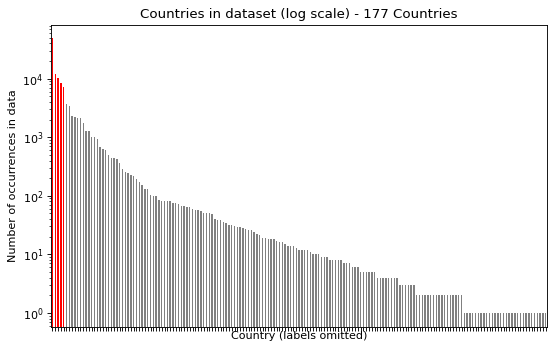

In [103]:
num_countries = d['country'].nunique()
print(f'There are {num_countries} countries in the original data, compared with {n_observations} observations.')
''' Plot the counts of individual countries on a log-lin scale '''
VV = pd.DataFrame(d['country'].value_counts().reset_index())
VV['clrs'] = np.where( (VV['index'].isin(['PRT','GBR','ESP','FRA','DEU'])) , 'red', 'grey')
var_count_df = d.country.value_counts()

var_count_df.plot.bar(var_count_df, logy=True, color = VV['clrs'])
plt.tick_params(labelbottom=False)
plt.title(f'Countries in dataset (log scale) - {num_countries} Countries')
plt.ylabel('Number of occurrences in data')
plt.xlabel('Country (labels omitted)')

percent_to_keep = 0.05 # Choose to keep countries apprering in at least 'percent_to_keep' observations
print(f'We are keeping {percent_to_keep*100}% of {len(var_count_df)} countries. Threshold = {percent_to_keep * n_observations}')#\n These are:')
var_count_df[var_count_df > (percent_to_keep*len(d['country']))]

# Create list of countries to remove (compliment of previous line)
var_count_df = var_count_df[var_count_df < (percent_to_keep*len(d['country']))]
# Get indices of the ones to keep
indices_ = []
for i in range(len(var_count_df)):
    indices_.append(var_count_df.index[i])
#indices_
#print('Countries to drop: \n',list(indices_))
d['country'] = np.where(d['country'].isin(indices_),'OTHER',d['country'])
print('Named Countries Retained:' ,d['country'].unique())


#### Dropping variables from the dataframe

From the analysis made so far, the following features will be deleted from the dataframe which include original features such as any additional fields that have arisen naturally as part of engineering. Only those that were part of the original dataframe have been discussed.


In [105]:
# Dropping dependant fields not required for models. Full Dataset is stored in d_FULL for data analysis at the end of the models.  
d_FULL = d.copy()
d.drop(['ISO3166-1-Alpha-3','ISO3166-1-Alpha-2','ISO4217-currency_country_name','Region Name',
        'FX_Rates_on_booking','FX_Rates_on_arrival','Continent','Currency_code' , 'distance(km)','arrival_date' , 'booking_date',
        'arrival_date_week_number','arrival_date_day_of_month','Currency_y', 'Currency_code','agent','company','day',
        'Year','month','arrival_date_year','assigned_room_type','required_car_parking_spaces','distribution_channel'],axis =1, inplace=True )

d['FX_Delta'] = d['FX_Delta'].replace(np.nan, 0)

# 3. Model Fitting and Tuning

The strategy adopted here is to trial four different models, namely logistic regression, support vector machines, decision trees and random forest. These were initially selected on the basis of the need for a binary classification output (no cancellation vs cancellation). First we outline the functions needed to complete the analysis, and we only provide the full code for the final model selected, random forest. Justification for staying with random forest model  is based in the results of the confussion matrix as we prioritise the outcome for false positives as we aim to minimise it given the losses it may generate for double room assignment.


For other models (distinct from random trees), we provide descriptions and refer the reader to 'external_functions.py'.


## Functions for modelling
General train and test splitting for all models so that we can directly compare the output probabilities.

In [106]:
''' This cell conducts the test/train split of the data used in all models.'''
#Code for onehotting 
d_onehot = d.copy()
d_onehot = pd.get_dummies(d_onehot)
d_onehot_labels = d_onehot.columns

# Drop the labels from data and create 
X = d_onehot.drop('is_canceled', axis = 1)
y = d_onehot['is_canceled']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Output basic properties of test/train split 
print("Dimension of Train set",X_train.shape)
print("Dimension of Test set",X_test.shape,"\n")
# Split Dataset into Continous and Categorical features in training set
num_cols = X_train._get_numeric_data().columns
print("Numerical Features in Dataset:",num_cols.size)
print("Categorical Features in Dataset:",(len(X_train.columns) - num_cols.size))

Dimension of Train set (95512, 63)
Dimension of Test set (23878, 63) 

Numerical Features in Dataset: 63
Categorical Features in Dataset: 0


In [120]:
truth = pd.Categorical.from_codes(y_test, categories = ('not cancellation','cancellation'))

def confusion_plot(truth, probs, threshold=0.5, plot=True):
    '''Function to produce the confusion matrix data and a stripplot to 
    visualise the data of the confusion matrix for a given threshold
    Input: truth: array of labels to replace 0/1 binary output
           probs:  array of predicted probabilities of observations
           threshold: default 0.5
           plot: default True, whether or not to produce plot as stdout
    Output: confusion matrix data from sklearn.metrics.confusion_matrix for data y
     '''
    d = pd.DataFrame(
        data = {'spam': y_test, 'truth': truth, 'probs': probs})
    
    # Create a column called outcome that contains the labeling outcome
    # for the given threshold
    d['outcome'] = 'other'
    d.loc[(d.spam == 1) & (d.probs >= threshold), 'outcome'] = 'true positive'
    d.loc[(d.spam == 0) & (d.probs >= threshold), 'outcome'] = 'false positive'
    d.loc[(d.spam == 1) & (d.probs <  threshold), 'outcome'] = 'false negative'
    d.loc[(d.spam == 0) & (d.probs <  threshold), 'outcome'] = 'true negative'
    
    if plot == True:
        # Create plot and color according to outcome
        plt.figure(figsize=(12,4))
        plt.xlim((-0.05,1.05))
        sns.stripplot(y='truth', x='probs', hue='outcome', data=d)
        plt.axvline(x=threshold, linestyle='dashed', color='black', alpha=0.5)
        plt.title("threshold = %.2f" % threshold)
        plt.show()
    
    return sklearn.metrics.confusion_matrix(y_true=d.spam, y_pred=d.probs >= threshold)


In [108]:
def true_false_evolution(probs, thresholds_input = np.linspace(0,1,10)):
    '''Plots the evolution of tp, fp, fn, tn with threshold. Calls the confusion_matrix
    function to calculate the tp, fp, fn, tn for each input thresholds
    Input: array of threshhold_inputs.
    Output: Plot visualisation to allow decision making on threshold '''
    # initialise thresholds
    thresholds_plot = np.empty((4,len(thresholds_input)))
    #Create matrix of tp,fp,fn,tn data over thresholds
    for i in range(len(thresholds_input)):
        conf_matrix = confusion_plot(truth, probs, threshold=thresholds_input[i], plot=False)
        tn, fp, fn, tp = conf_matrix[0][0], conf_matrix[0][1], conf_matrix[1][0], conf_matrix[1][1]
        thresholds_plot[0][i] = tp
        thresholds_plot[1][i] = fp
        thresholds_plot[2][i] = fn
        thresholds_plot[3][i] = tn
    categories = ['tp','fp','fn', 'tn']
    for i in range(0,4):
        plt.plot(thresholds_input, thresholds_plot[i], label=categories[i])
        plt.xlabel('Threshold Value in [0,1]'), plt.ylabel('Count')
        plt.title('Evolution of TP, FP, FN, TN with Threshold.'), plt.legend()
       

In [109]:
def probs_histogram(model_used):
    '''Short tool for assessing balance of predicted data.
    Input: the model we wish to evaluate
    Output: Prints the number of 0 and 1 in the original data to show balance
            Plots probability distribution of the model output (predictions) '''
    print('Count of labels 0 and 1 in the data to indicate balance:\n',d['is_canceled'].value_counts())
    plt.hist(model_used.predict_proba(X_test)[:,1].reshape(-1))
    plt.xlabel('Probability (binned)'), plt.ylabel('Count')
    plt.title('Distribution of probability amongst observations.'), plt.show()

In [110]:
def roc_plot(y_true, y_pred, plot = True):
    """ Draw an ROC curve and report AUC 
    Input: true y data, predicted y data
    Output: (to stdout) display ROC curve
    returns dataframe containing roc curve information
    """
    roc = pd.DataFrame( data = np.c_[sklearn.metrics.roc_curve(y_true, y_pred)],
        columns = ('fpr', 'tpr', 'threshold'))
    
    if plot == True:
        sns.lineplot(x='fpr', y='tpr', data=roc, ci=None)
        plt.plot([0,1],[0,1], 'k--', alpha=0.5) # 0-1 line 
        plt.title("ROC curve (auc = %.4f)" % sklearn.metrics.roc_auc_score(y_true, y_pred))         
        plt.show()
        
    return roc, sklearn.metrics.roc_auc_score(y_true, y_pred)

In [111]:
def plot_feature_weights(importances, Tolerance = 0.5, plot=True):
    ''' Plot the feature importances predicted by a model.
    Input: importances from the model (ndarray), plot: boolean to display plot
           Tolerance, decimal (>0) above which we consider features significant.
    Output: Displays  feature importances as bar chart if plot = True 
            returns dataframe of model coefficients for further analysis. '''
        
    model_Coefs = pd.DataFrame(importances, columns = {'coefficients'})
    model_Coefs['Feature'] = d_onehot_labels[1:]
    model_Coefs = model_Coefs.sort_values(by = 'coefficients' )
    model_Coefs["Coefficients Correlation"] = np.where(model_Coefs["coefficients"]<0, 'Negative Weights', 'Positive Weights')

    #model_Coefs.drop(model_Coefs[(model_Coefs['coefficients'].eq(0)) | (abs(model_Coefs['coefficients']) < Tolerance )].index, inplace = True)
    palette = {'Negative Weights': "#ff0000", 'Positive Weights': "#00ff00"}

    if plot == True:
            fig, ax = plt.subplots(figsize=(20, 7)) 
            feature_plot = sns.barplot(data = model_Coefs.drop(model_Coefs[(model_Coefs['coefficients'].eq(0)) | (abs(model_Coefs['coefficients']) < Tolerance )].index),                     
                    y='coefficients',x = 'Feature' , hue = 'Coefficients Correlation' , ax=ax , palette=palette )
            feature_plot.set_xticklabels(feature_plot.get_xticklabels(), rotation=45, horizontalalignment='right' )
            #ax.set_xlabel('Features within the Lasso Model')
            ax.set_ylabel('Coefficient values')
            plt.title(f'Coefficients of the Features')# \n (Coefficients > absolute value {Tolerance})')
            plt.show()
            
    return model_Coefs

In [113]:
def display_results_report(model_fitted, X_train, X_test, y_train, y_test, y_hat, short=False):
    ''' Displays the '''
    if short == False:
        # View the accuracy score
        print(f'_____ GridSearchCV Model Results_____') 
        print("Best params: ", model_fitted.best_params_)
        print("Training set score: %f" % model_fitted.score(X_train , y_train))
        print("Testing  set score: %f" % model_fitted.score(X_test  , y_test ))

    # Now inspect the final model
    final_model = model_fitted.best_estimator_
    #Y_pred_svm = model_fitted.predict(X_test)
    print("Precision:",precision_score(y_test, y_hat),'\n')

    print('_____ Confusion Matrix_____ : \n',confusion_matrix(y_test,y_hat))

    if short == False:
        print('_____ Classification Report_____ : \n',classification_report(y_test,y_hat))
    print('% False positive for cancellation',round(confusion_matrix(y_test,y_hat)[0,1]/ sum(confusion_matrix(y_test,y_hat)[0,:]),5)*100)
    print('% False negative for cancellation',round(confusion_matrix(y_test,y_hat)[1,0]/ sum(confusion_matrix(y_test,y_hat)[1,:]),5)*100)

## Model Trials


### Logistic regression

As a baseline model, we trial the logistic regression model. We apply cross validation with 5 KFolds, and values of 'logisticregression__C':  np.linspace(0.1, 10, 10).  The pipeline and model for logistic regression is not presented here as we will see later that a different model was chosen, but we use the key results as justification going forward.

In [ ]:
logreg_model = external_functions.logistic_pipeline(X_train, y_train)

In [187]:
Y_hat_logreg = logreg_model.predict(X_test)
display_results_report(logreg_model, X_train, X_test, y_train, y_test, Y_hat_logreg, short = True)

# Get ROC plot and associated AUC measurement
test_set_predictions = logreg_model.predict_proba(X_test)[:,1].reshape(-1) 
roc_df, roc_auc = roc_plot(y_test, test_set_predictions, plot = False)
print(f'This model gives and AUC of: {round(roc_auc,5)}') 
logreg_coefs = pd.DataFrame(logreg_model.best_estimator_.steps[1][1].coef_[0], columns = {'coefficients'})

Precision: 0.7968615030233228 

_____ Confusion Matrix_____ : 
 [[13523  1411]
 [ 3409  5535]]
% False positive for cancellation 9.447999999999999
% False negative for cancellation 38.115
This model gives and AUC of: 0.87488


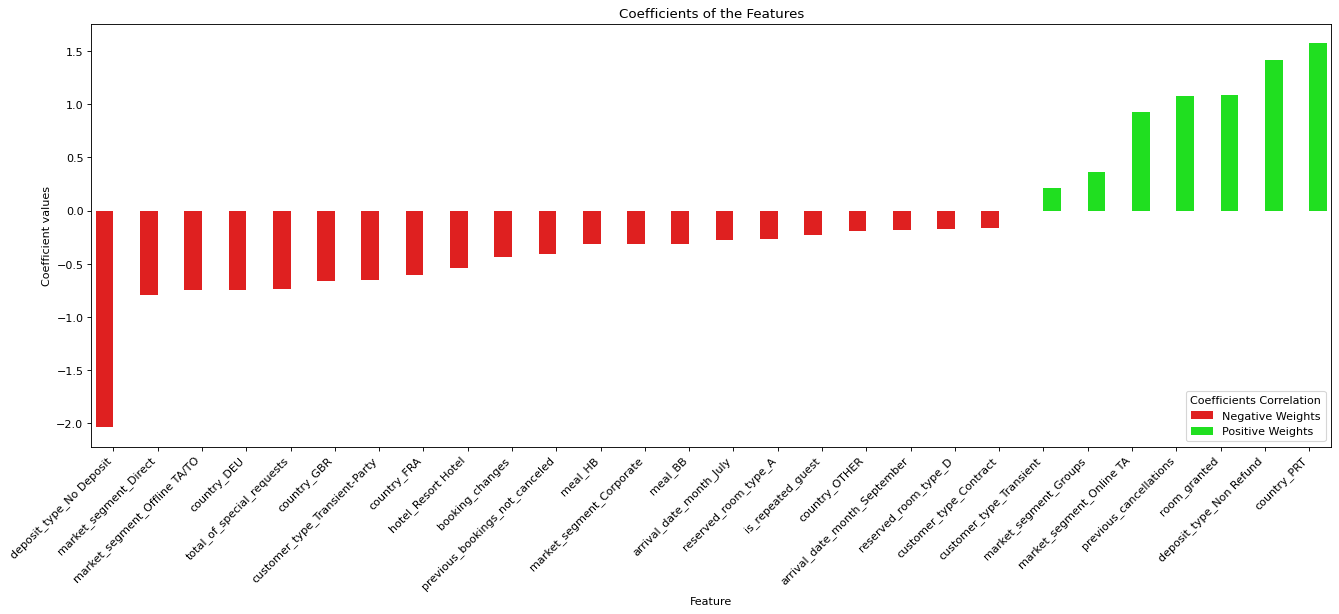

In [252]:
importance_logreg = logreg_model.best_estimator_.steps[0][1].coef_[0]
logreg_Coefs = plot_feature_weights(importance_logreg, Tolerance = 0.15, plot = True)

##### Summary/Rejection Rationale:
The confusion matrix and percentages calculated above show a significant number of false positives (approx 20%). We show a AUC and precision of 0.88 and 0.81 respectively. These results imply that the model has performed well, but we would like to further minimise false positives in our hotel context, as it constitutes the double booking scenario. Thus, we continue with other models.

### Support vector machines

We implemented SVC with cross validation by 5 KFolds, a scaled Gamma, with standard scaler normalisation and a gridsearchcv over a parameter grid using RBF, Linear and Poly Kernels, and a range of 1 to 4 degrees for the polynomial. The optimal model for a sample of 1% of the data was found to be a linear model of 2 degrees, and a C of 0.1. 


#### Rejection Justification
A 1% sample of the data resulted in a model which took several hours to complete; when scaled to 5% of the data the model did not conclude with >9hours of training. We have discovered that in the current context, SVM takes a prohibitively long time to run, even for the simple parameter spaces defined here. We also note that the SVM does not scale well to large datasets. Specifically the SVM model uses a kernel matrix which is $n\times n$, and in this case this equates to $10^{10}$ elements, which is a very large amount of memory and renders it intractible as a solution here. 
______________
[https://stats.stackexchange.com/questions/314329/can-support-vector-machine-be-used-in-large-data] 

### Decision tree

For the following two models (decision tree and random decision tree) we use gini impurity which minimises the probability of misclassification. We decided to use gini instead of entropy, given that computing a probability$^2$ function  is cheaper than one of logarithmic type. We set a grid search of a list (1,20) as we care about overfitting and thus this is a way of avoiding it (limiting the tree depth). Finally, as before we used 5 folds to train our model.

In [44]:
# Run the model (pipeline in external file for brevity)
dectree_model = external_functions.dectree_pipeline(X_train, y_train)

In [213]:
# Show results
probs_tree = dectree_model.predict_proba(X_test)
y_hat_dectree = dectree_model.predict(X_test)

display_results_report(dectree_model, X_train, X_test, y_train, y_test, y_hat_dectree, short = True)

# Get ROC plot and associated AUC measurement
test_set_predictions = dectree_model.predict_proba(X_test)[:,1].reshape(-1) 
roc_df, roc_auc = roc_plot(y_test, test_set_predictions, plot = False)
print(f'This model gives and AUC of: {round(roc_auc,5)}')


Precision: 0.8075056232982124 

_____ Confusion Matrix_____ : 
 [[13308  1626]
 [ 2123  6821]]
% False positive for cancellation 10.888
% False negative for cancellation 23.737
This model gives and AUC of: 0.90944


##### Summary/Rejection Rationale
We see here a significant portion of false positives once again, but a much smaller percentage of false negatives. We show a good value for AUC indicating the model does well, but given our priority of reducing false positive, we continue to other alternatives.

## Random forest trees Model

This model is selected as an improvement of the tree classification. With the use of random forest trees we reduce the variance of an estimator and thus reduce overfitting while increasing our prediction accuracy. In this case, the grid search contained up to 100 trees as averaging more trees will yield to a robust ensamble, and a depth grid of 1 to 7 as another way to avoid overfitting (limiting the tree depth). Once again, we train the model by splitting into five folds.




 Decision trees allow us assess the importance of each feature for classifying the data,


Important features mean the features that are more closely related with dependent variable and contribute more for variation of the dependent variable. We can not directly interpret them as how much change in Y is caused due to unit change in X(j), keeping all other features constant

In [29]:
'''Full model for Random Forest Classifier. '''
pipe_random_forest = make_pipeline(
            RandomForestClassifier(
            random_state=42,
            criterion='gini')
            )
parameters = { 'randomforestclassifier__max_depth': list(range(1,7)),
                'randomforestclassifier__n_estimators': [20, 50, 100] } #list(range(1,100))

kf = KFold(n_splits=5, shuffle=True, random_state=0) # Cross Validation
models_tree_random = GridSearchCV(pipe_random_forest, param_grid = parameters, 
                    scoring="accuracy", cv=kf,return_train_score=True)
models_tree_random.fit(X_train, y_train) # Model fitting

y_hat_random_forest = models_tree_random.predict(X_test)

Results from the model above:

In [135]:
display_results_report(models_tree_random, X_train, X_test, y_train, y_test, y_hat_random_forest, short=False)

_____ GridSearchCV Model Results_____
Best params:  {'randomforestclassifier__max_depth': 6, 'randomforestclassifier__n_estimators': 50}
Training set score: 0.774154
Testing  set score: 0.770123
Precision: 0.9789298586082618 

_____ Confusion Matrix_____ : 
 [[14858    76]
 [ 5413  3531]]
_____ Classification Report_____ : 
               precision    recall  f1-score   support

           0       0.73      0.99      0.84     14934
           1       0.98      0.39      0.56      8944

    accuracy                           0.77     23878
   macro avg       0.86      0.69      0.70     23878
weighted avg       0.83      0.77      0.74     23878

% False positive for cancellation 0.509
% False negative for cancellation 60.521


##### Summary/Acceptance Rationale:
Due to the low percentage of false positives seen for the random trees model, combined with the good level of precision this model is selected and analysed further in the next section.

# 4. Discussion & Conclusions

## Functions needed:


In [31]:
def categorical_data_viewer(DataFrame, StartsWith = '', Tolerance = 0 , DeleteZeros = 'Y'):
    DataFrame = DataFrame[DataFrame['Feature'].str.match(StartsWith)].copy()
    DataFrame.loc[:,'Feature'] = DataFrame.loc[:,'Feature'].str.replace((StartsWith+'_'),'')
    
    if DeleteZeros == 'Y':
        DataFrame.drop(DataFrame[(DataFrame['coefficients'].eq(0)) | (abs(DataFrame['coefficients']) < Tolerance )].index, inplace = True)
    else:
        DataFrame.drop(DataFrame[(abs(DataFrame['coefficients']) < Tolerance )].index, inplace = True)

    return DataFrame

## Model Performance

In the following plot we analyse different values for the true and false positives such as the true and false negatives, in order to define which should be the correct threshold. Let recall that our aim is to reduce the number of false positives as we care about predicting cancellations when the guests actually do not cancel. Thus, it can be seen that with a threshold of .6 the percentage of false positives is .4% while the percentage of false negatives is 63.2%. However, by using the default threshold of 0.5 we get a percetentage of false positives of .5% but we decrease our false negative to 60.5%. Therefore, eventhough we care more about false positives, we decide to continue with the default threshold as it gives a more balanced value for false predictions.

Values given by using a threshold of 0.5 :
tp: 3531, fp: 76, fn: 5413, tn: 14858


array([[14858,    76],
       [ 5413,  3531]])

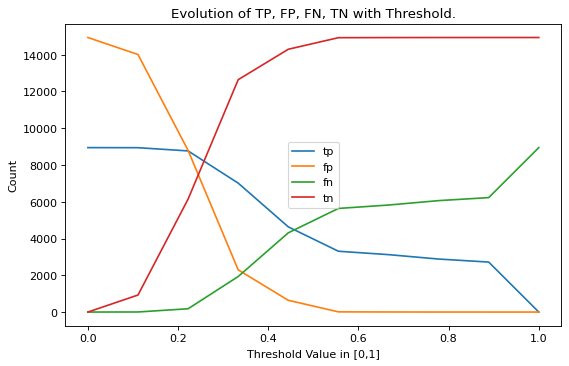

In [214]:
threshold = .5
probs_random_forest = models_tree_random.predict_proba(X_test)[:,1]
true_false_evolution(probs_random_forest, thresholds_input = np.linspace(0,1,10))
conf_matrix = confusion_plot(truth, probs_random_forest, threshold=threshold, plot = False)

print('Values given by using a threshold of', threshold, ':')
tn, fp, fn, tp = conf_matrix[0][0], conf_matrix[0][1], conf_matrix[1][0], conf_matrix[1][1]
print(f'tp: {tp}, fp: {fp}, fn: {fn}, tn: {tn}')
conf_matrix

The following histogram ilustrates the balance of predicted probabilities accross the data. This plot shows that the distribution is non uniform as expected, but there are a significant number of the observation probabilities centered around 0.3, and another peak at 0.9. This does show some imbalance in the data but is not so extreme that the model has been seriously degraded. Recall for reference the imbalance in the original data labels, where there were 63% non cancellations and 37% cancellations.

Count of labels 0 and 1 in the data to indicate balance:
 0    75166
1    44224
Name: is_canceled, dtype: int64


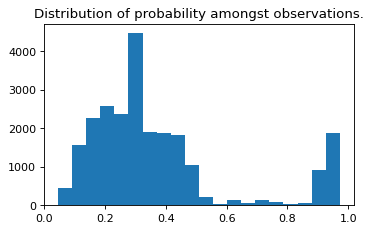

In [223]:
# How balanced is the distribution of the data labels
print('Count of labels 0 and 1 in the data to indicate balance:\n',d['is_canceled'].value_counts())
fig_hist = plt.figure(figsize=(5,3))
fig_hist = plt.hist(models_tree_random.predict_proba(X_test)[:,1].reshape(-1),bins=20)
plt.title('Distribution of probability amongst observations.')
plt.show()

By using the ROC curve, we can see another method of the effect of choosing different thresholds, as it plots the true positive rate against the false positive rate for different threshold values. The AUC value is refered to the probability that the classifier will predict a randomly cancellation higer than a randomly no cancellation. In this case we can see we have an AUC value pretty close to one which we might interpret as the model is giving the correct predictions.



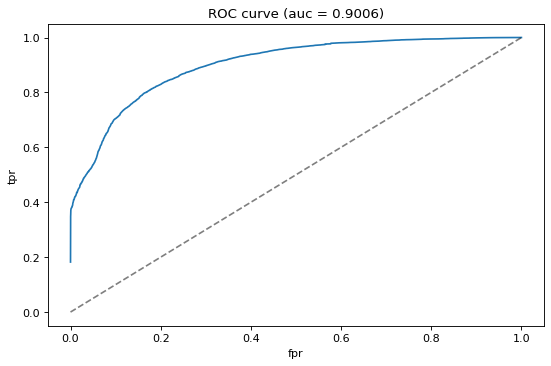

pandas.core.frame.DataFrame

In [183]:
# sup. all looks good
test_set_predictions = models_tree_random.predict_proba(X_test)[:,1].reshape(-1)
#print(y_hat_random_forest)
roc_df = roc_plot(y_test, test_set_predictions, plot=True)#Y_hat_logreg)
type(roc_df[0])

## Explanation of Results

### Feature Importance 

We should note here that with random forest classifiers, we do not obtain the weight of each feature as in logistic regression, but we get the feature importance (a measure of predictive power). The key difference being that the importance does not allow us to detail exact behaviour of a feature with respect to the output variable, e.g. lead time has a high importance but we cannot say if the higher the lead time the higher he cancellations or the higher the lead time the less number of cancellations as we do not have the sign value (as in logisitc regression).

However, we can make use of the signs obtained in the weights from logistic regression, in order to help intuititively interpret the behaviour between the features and the dependant variable. It is important to recall, that logistic regression is not the model chosen for predicting cancellation, and we refer to it only to help with intuition. We can see Green (Positive weights) which show importance of a more likely to cancel, and red (negative weights) to show the importance of a feature not cancelling. 

#### Brief Summary of findings:
Each feature in the data is given a relative importance by the model in terms of its influence on the capacity to predict cancellation. The importance scores displayed here show that if a customer has no deposit, or a refundable deposit (`deposit_type_No_Deposit`, `deposit_type_Non_Refund`), these are the strongest indications of future cancellation. It also reveals the bookings originating in Portugal itself (`country_PRT`) and longer lead times (`lead_time`) are important. We observed previously that a lot of the bookings in the data are from Portugal, so unsurprisingly we are seeing this as important here, and lead time indicates that the customers booking far in advance are also important to cancellations. It is also not surprising that if a customer does not recieve the room they expected (`room_granted`), if they have cancelled before (`previous_cancelations`), or if they make a lot of special requests (`total_of_special_requests`) then this is perhaps indicative of their uncertainty in booking in the first instance.


The following graph combines the feature importance obtained by the random forest model and just add the signs of the coefficients obtained by the logistic regression. This graph was created to give a further explanation of the importance and possible behaviour of the features with respect to the dependant variable. Nevertheless, we should give the whole importance to the results obtained by the random forest.

<function matplotlib.pyplot.show(close=None, block=None)>

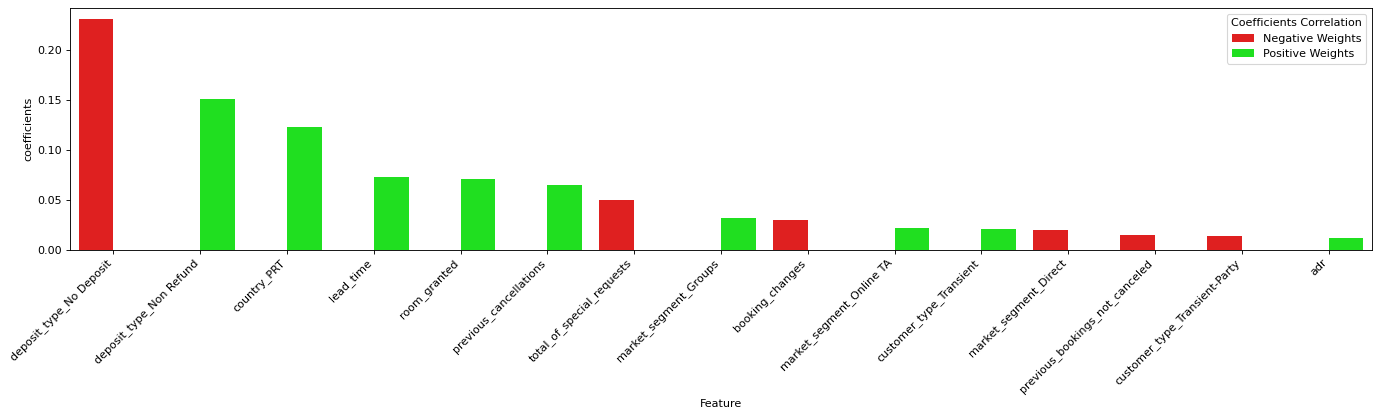

In [278]:
#Create the importance DataFrame & Join on the Direction of the coefficients from logistic regression. 
RandTree_Imp =  pd.DataFrame(feature_imp_tree_random).reset_index()
RandTree_Imp.columns = (['Feature', 'coefficients'])
RandTree_Imp = pd.merge(logreg_Coefs[['Feature', 'Coefficients Correlation']], RandTree_Imp, on = 'Feature')

palette = {'Negative Weights': "#ff0000", 'Positive Weights': "#00ff00"}
fig, ax = plt.subplots(figsize=(21, 4)) 
plot = sns.barplot(data =RandTree_Imp.sort_values(by='coefficients', ascending=False).head(15),
x ='Feature',
y = 'coefficients' , hue = 'Coefficients Correlation' , palette=palette , ax=ax )
plot.set_xticklabels(plot.get_xticklabels(), rotation = 45, horizontalalignment = 'right')
plt.show

#### Previous Bookings (more detail)

Whether the agent/customer has previous cancellations is one of the top importance features. As stated before, we can not infer a direct behaviour from the feature importance result, but from the original data and in fact reassuring with the sign given by the logistic regrssion, we can say that if a customer has more prior cancellations, then they are more likely to cancel again, which fits with intuition of customers habits.
<!-- This is useful to know, as this is a measure of trust in the customer/agent that they will fulfill their booking and will not cancel. A higher value of previous cancellation results in a lower degree of trust, which does not require a machine learning algorithim to solve, however this model has successfully quantified this relationship and confirmed that customers/agents who frequently cancel are likely to repeat this in the furture.  -->

If we ignore the _number_ of cancellations, and look solely from a binary perspective of "does this booking have previous cancelation history?". The left plot shows bookings with no prior cancellations with month of booking, and we see almost no cancelations year-round. Whereas for those _with_ previously cancelled bookings, there is a sizable proportion of cancellations, particularly between June and November which is further indicative of a seasonal trend. 

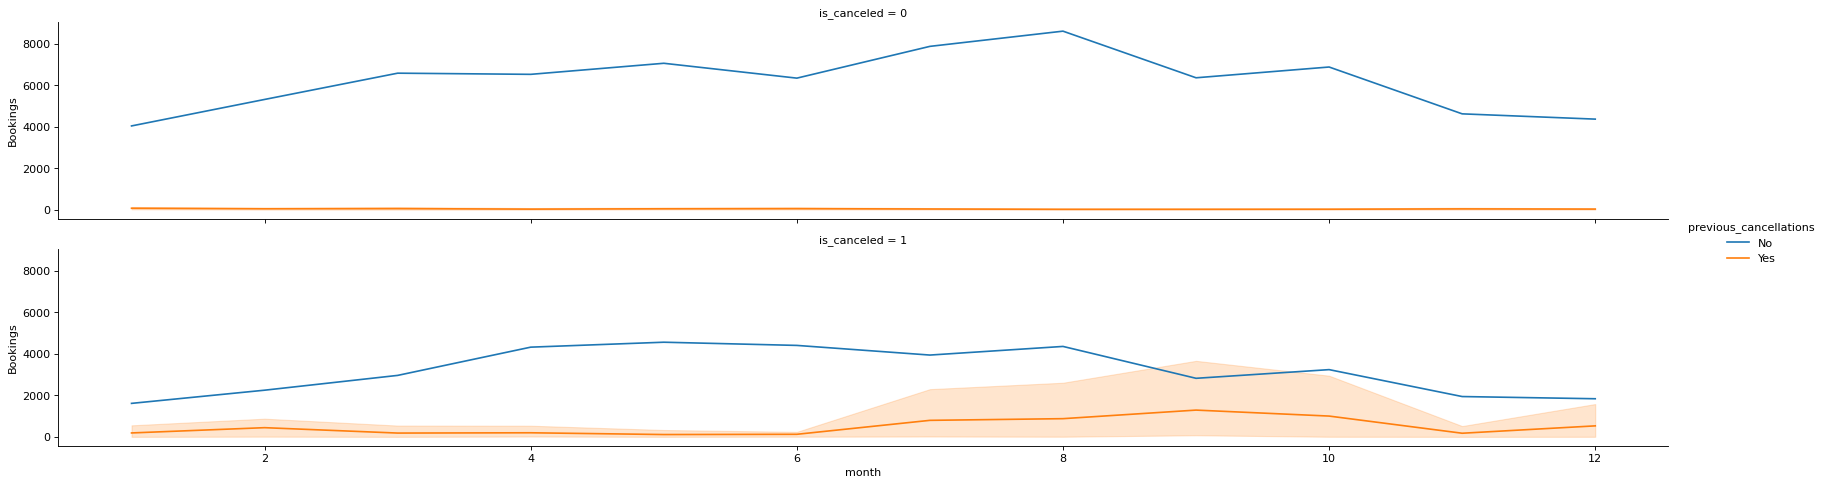

In [293]:
prev_cancel = d_FULL.groupby(['month', 'previous_cancellations', 'is_canceled' ]).agg({'lead_time':'count'}).reset_index()
prev_cancel['previous_cancellations'] = np.where((prev_cancel['previous_cancellations']>0) ,'Yes', 'No' )
prev_cancel.rename(columns={'lead_time':'Bookings'}, inplace = True)
sns.relplot(data=prev_cancel, x="month", y="Bookings", row="is_canceled", hue="previous_cancellations", kind="line" , height=3, aspect=7 ,estimator = 'sum' )

#### Cost to the Customer

The `deposit_type` feature proved to be the most influencial within the dataset, specifically for "No Refund" & "No Deposit". In this case, we decided not to follow the insight provided by the logistic regresion to explain its behaviour with our dependant variable as it might be contra-intuitive. Instead we show the following plot which matches with the insight expected, the more non deposit bookings the more likely the guest is to cancel. However, in the case of non refundable bookings we have no data available for 'non cancellations' (unbalanced feature), therefore, we see that whenever there exists a non refundable booking there exists a cancellation, which does not match with our intuition. In this case, we advice just to maitain the insight of the feature importance and don not provide an specific behaviour.


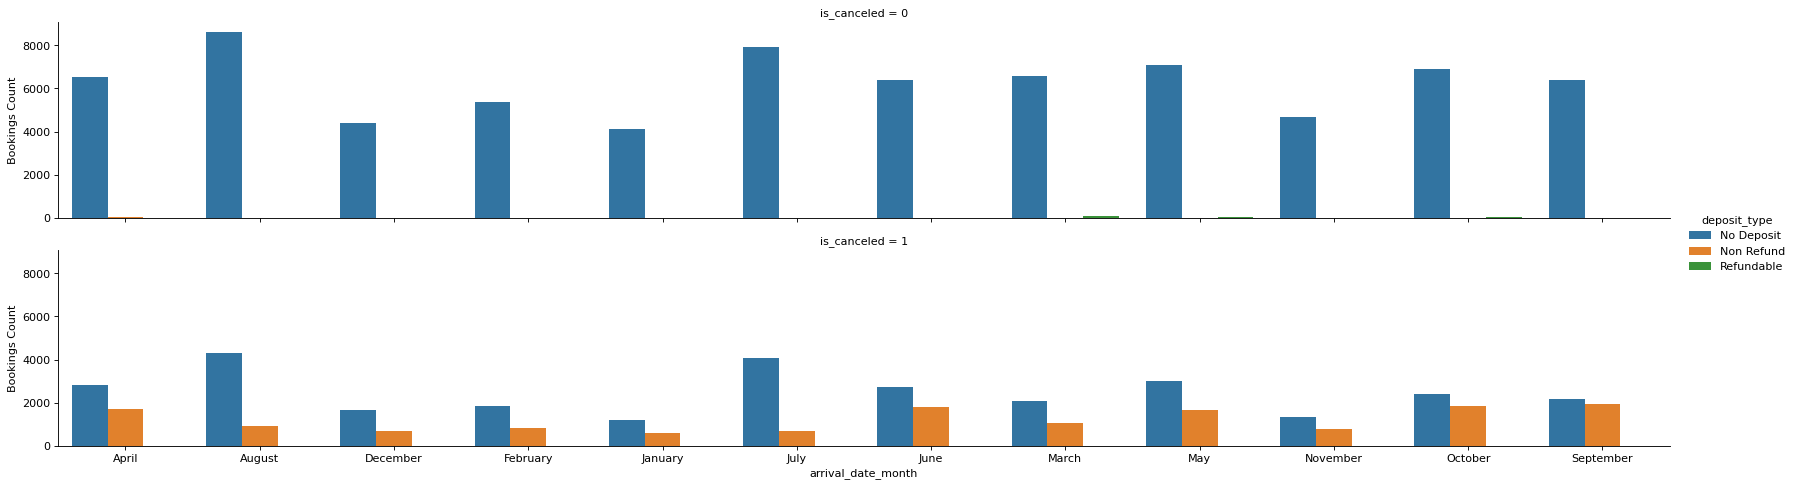

In [292]:
deposits =  d_FULL.groupby(['deposit_type', 'arrival_date_month', 'is_canceled']).agg({'adr':'count'}).reset_index()
deposits.rename(columns = {'adr':'Bookings Count'}, inplace = True)
p = sns.catplot(data = deposits, x = 'arrival_date_month' , y = 'Bookings Count', kind = 'bar' , hue = 'deposit_type' , row = 'is_canceled' , height = 3, aspect = 7)


#### Customer Profiling
We have information on the number of special requests and booking changes that a customer makes to a booking, and whether they have made cancellations before. This information could be used in a profiling exercise to identify groups of customers that are potentially most unreliable, i.e. more likely to cancel. This could present an ethical challenge, such that customers could be discriminated against based on this behaviour and these bookings avoided. This is not ethical, recommended, or done here.


From the results, we would recommend that the hotels favour customers which have made special requests, and those who have booked directly, as the importance results show this leads to customers fulfilling their booking (see `total of special requests` & `market_segment_direct` results). Transient groups should be favoured over transient individuals for the same reason, as there these groups feature highly in the Random Forrest importance results.

#### Country Discussion

The only conclusion from the analysis is that domestic travel (guests from Portugal) have a higher likleihood of cancellation. We can see that Spanish & Portoguise Guests are the most likely to cancel, which also have the shortest distance to Travel. Guests from the UK, Germany & France all show no great relationship with whether they shall cancel or not. The distance between the country of the customer booking and  Portugal was not included, but upon analysis does not show any imporance on the top 5 countries. 

We also see very low importance of the FX Delta (not noteworthy, but mentioned as this was an engineered feature) the difference in the currency strength at booking compared to arrival time. 

### Economic Viability

The random forest classification has been selected due to its ability to drastically reduce the false positive cases, where we predict that there will be a cancellation, but the guest does not cancel. This 'double booking' is assumed to be the worst possible scanario as not only the hotel lose business, but potentially must provide alternative accommodation to displaced guests at their own cost. 

Therefore, if we assign a cost of 1 unit for false negatives, and 2 units to the double booking scenario, we can assess the costs from the model.
Calculated simply using 

$C_{total} = C_{FN}(N_{FN}) + C_{FP}(N_{FP})$ where $C_{FN}, C_{FP}$ are the costs of false negative and false positive respectively, and $N_{FN}, N_{FP}$ are the numbers of false negative and false positive respectively.

The confusion matrix for random forest yields a total cost of 5565 units. If one unit is 100GBP, this equates to £556,500 per annum. For reference, Logistic regression gives a cost of 6231 units, and decision trees 5375 units. Despite decision trees being slightly cheaper, the decision  trees have a higher variance and thus we stick with the random forest classifier on this basis.

### Summary

We have shown here that our chosen random forest classification model successfully minimises the false positive double booking scenario, and have further shown that it provides a good prediction of cancellation by the ROC curve and AUC statistics. We have given details of the key results of the model above in order to provide intuition and impact of the results. We have take into account ethical considerations, and have also attempted to estimate the cost of our model under simplifying assumptions.

## 5. Convert Document

In [300]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf proj2.ipynb

[NbConvertApp] Converting notebook proj2.ipynb to pdf
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['text/html']) is not able to be represented.
  mimetypes=output.keys())
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['text/html']) is not able to be represented.
  mimetypes=output.keys())
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['text/html']) is not able to be represented.
  mimetypes=output.keys())
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['text/html']) is not able to be represented.
  mimetypes=output.keys())
[NbConvertApp] Support files will be in proj2_

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6d844b8b-c2b2-41b2-8d9c-38e9bb4a0873' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>